<a href="https://colab.research.google.com/github/Tendo15/MscDataObservations/blob/randomforest/RANDOM_FOREST_Group_Project__(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dataset details: https://www.kaggle.com/datasets/S%C3%ADrio-Libanes/covid19**
Download the dataset, unzip it and upload it into your Google Drive. Then create a folder, for example 'Group Project' and create a new Colab file in the folder.

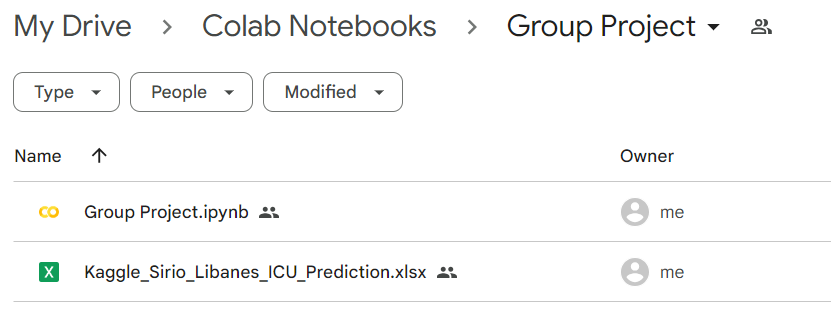

In [ ]:
!pip install dataprep
!pip install plotly.express

In [ ]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from dataprep.eda import plot, plot_missing, plot_correlation, create_report


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Grant Colab access to Google Drive, where the dataset is located

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)

Change your current directory accordingly. Tip: use the folder icon on the left toolbar in order to find the folder's filepath:
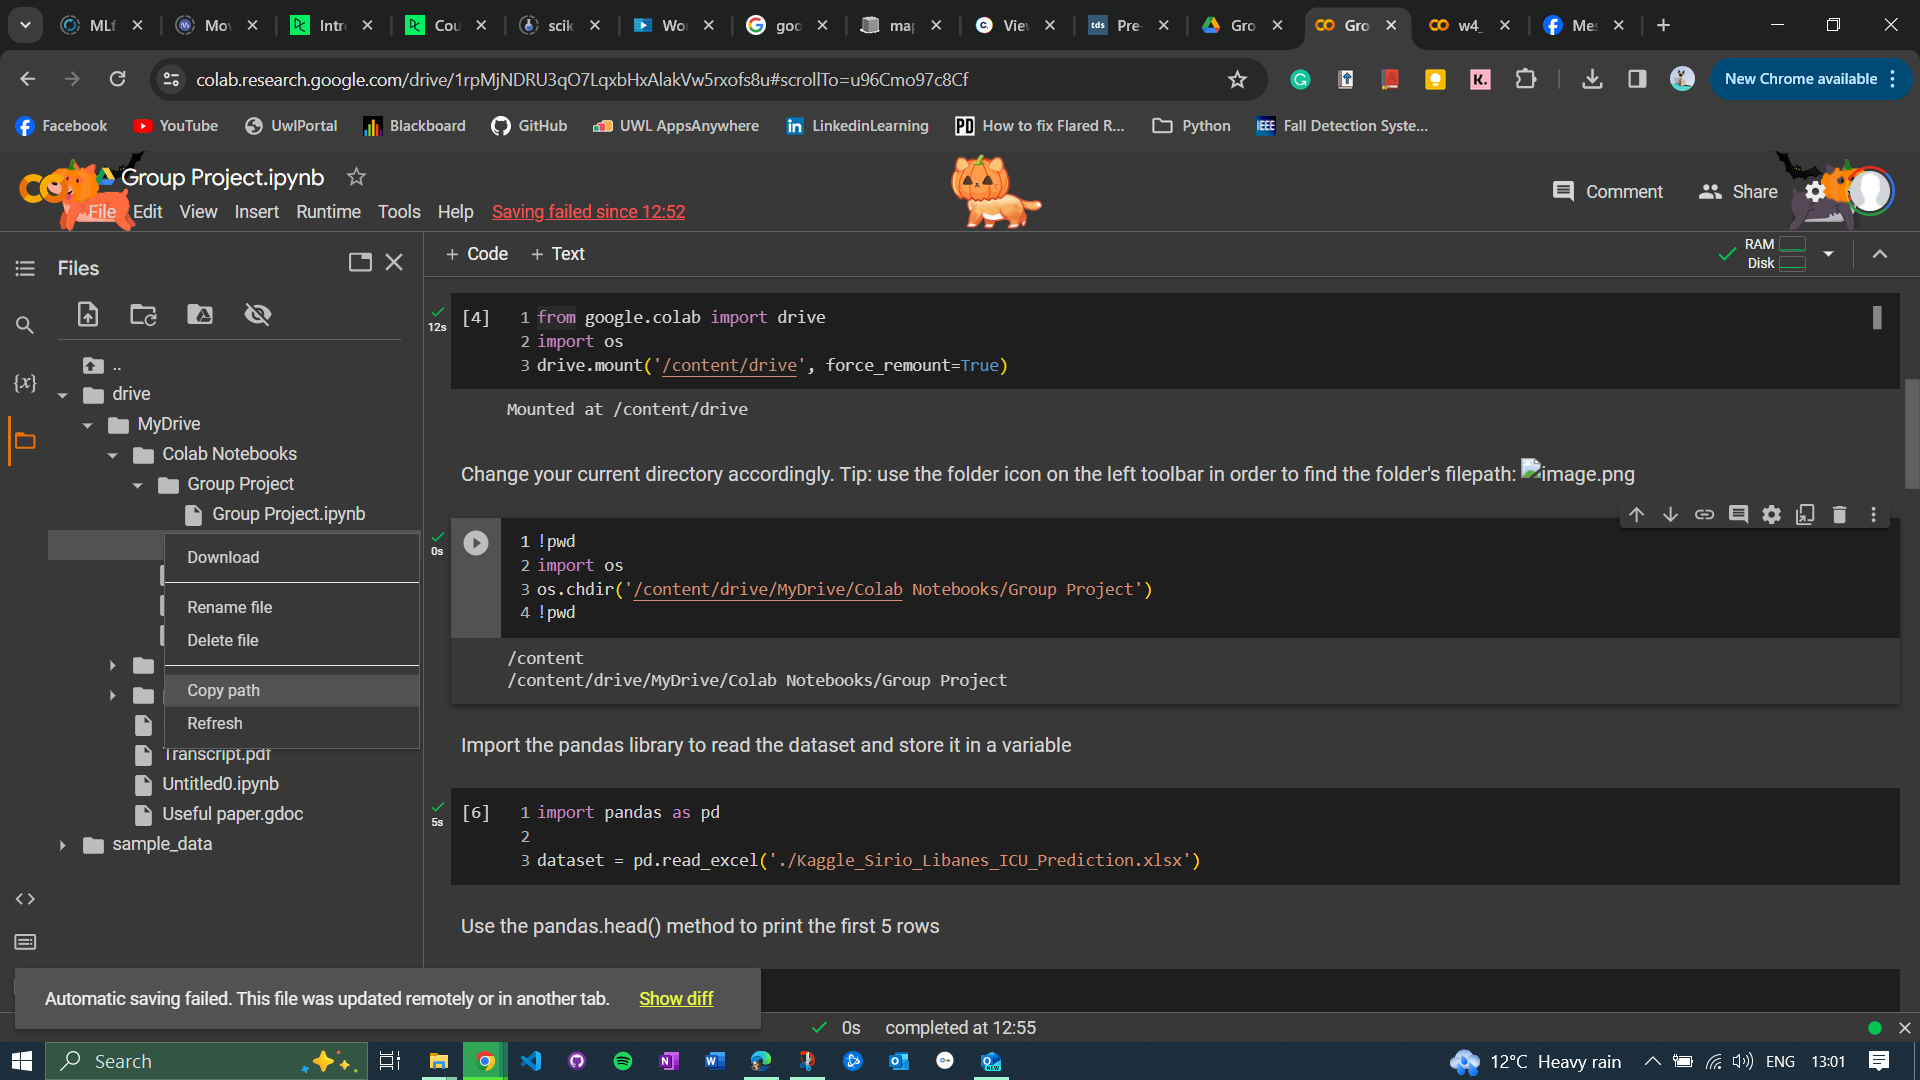

In [ ]:
!pwd
import os
os.chdir('/content/drive/MyDrive/ColabNotebooks2024/Group Project')
!pwd

Import the pandas library to read the dataset and store it in a variable

In [ ]:
import pandas as pd

dataset = pd.read_csv('./kaggle_sirio_libanes_ICU_Prediction copy.csv')
dataset.head()
print(dataset.shape)

# 1. Exploratory data analysis

## Dataset details

Use the pandas.head() method to print the first 5 rows

In [ ]:
dataset.head()

Print the shape of the dataset, which shows that there are 1925 rows of data, and 230 features (the ICU column is the target)

In [ ]:
dataset.shape

pd.info() shows some info regarding the dataset, with the dtypes being the most useful

In [ ]:
dataset.info()

pd.describe() does column-wise summary statistics: count, average, standard derivation, min, quartile ranges, max

In [ ]:
dataset.describe()

In [ ]:
# report = create_report(dataset)
# report.save('ICU_admissions_report')

# report

## Coulmn types

In [ ]:
data_types = dataset.dtypes.to_dict()

for col_name, col_type in data_types.items():
    print(f'Column {col_name}:  {col_type}')

In [ ]:
print(f'Number of integer columns: {dataset.select_dtypes(include="int").shape[1]}')
print(f'Number of float columns: {dataset.select_dtypes(include="float").shape[1]}')
print(f'Number of object(categorical) columns: {dataset.select_dtypes(include="object").shape[1]}')
print(f'Total number of columns: {dataset.shape[1]}')

We will save the two categorical columns in a variable that will be used for dummmification during data-preprocessing.

In [ ]:
categorical_cols = dataset.select_dtypes(include="object").columns
print(categorical_cols)
dataset[categorical_cols]

By looking at the datatypes alone we cannot differentiate between binary features and float/int features, hence we will use the pd.nunique() function to count the number of unique values per column; if a column has only two unique values it is highly probable that the feature is binary.

In [ ]:
dataset.columns[dataset.nunique(axis='index') <=2]

In [ ]:
dataset[dataset.columns[dataset.nunique(axis='index') <=2]].head()

In [ ]:
dataset.nunique(axis='index').sort_values()

By checking the head of the possible binary features we notice that the _DIFF columns have only one unique value, which requires further investigation

In [ ]:
dataset.columns[dataset.nunique(axis='index') == 1]

In [ ]:
dataset[dataset.columns[dataset.nunique(axis='index') == 1]].describe()

In [ ]:
plot(dataset[dataset.columns[dataset.nunique(axis='index') == 1]])

It seems that all the above _DIFF features have a constant value of -1. Having a column with a constant value is not beneficial to the model since the model would not get any information based on a feature with a constant value, hence these feature columns must be dropped.

In [ ]:
print(f'Dataset\'s number of columns before drop: {dataset.shape[1]}')
dataset.drop(dataset.columns[dataset.nunique(axis='index') == 1], axis='columns', inplace=True)
print(f'Dataset\'s number of columns after drop: {dataset.shape[1]}')

Checking possible binary features

In [ ]:
plot(dataset[dataset.columns[dataset.nunique(axis='index') == 2]])

After checking Dataprep's plots, it can be observed that the columns with only two values are indeed binary (including the target column 'ICU')

In [ ]:
binary_cols = dataset.columns[dataset.nunique(axis='index') == 2]
binary_cols

### Investigating 'int' columns

In [ ]:
dataset.select_dtypes(include='int')

The AGE_ABOVE65, GENDER, ICU columns that are of type int are actually binary, with the column PATIENT_VISIT_IDENTIFIER being the only true 'int' column.

### Investiating 'float' columns

In [ ]:
dataset.select_dtypes(include='float')

The float columns also include several 'binary' columns previously discussed, thus we will explore the columns that are true 'float' using the .difference() method which works by computing the set difference between the set of all columns and the set of binary columns.

In [ ]:
float_cols = dataset.select_dtypes(include='float').columns.difference(binary_cols)
float_cols

In [ ]:
dataset[float_cols]

In [ ]:
# plot(dataset[float_cols])

The dataframe containing only floats seems to be made out of the statistical columns (i.e. the columns ending in _MIN, _MAX, _MEAN, _MEDIAN, _DIFF). Let's test our assumption:

In [ ]:
# Create a list of all statistical columns
statistical_cols = []
for column in dataset.columns:
    if "MIN" in column or "MAX" in column or "MEDIAN" in column or "MEAN" in column or "DIFF" in column:
        statistical_cols.append(column)

# Extract the columns that contain MIN, MAX, MEDIAN, MEAN, or DIFF
dataset[statistical_cols].shape

# Print the extracted columns
print(len(statistical_cols))

In [ ]:
len(float_cols)

In [ ]:
set(statistical_cols) == set(float_cols)

In [ ]:
numerical_cols = dataset.columns.difference(categorical_cols).difference(binary_cols)
len(numerical_cols)

In [ ]:
print(f'Number of numerical features in the dataset: {dataset[numerical_cols].shape[1]}')
print(f'Number of binary features (including the target feature) in the dataset: {dataset[binary_cols].shape[1]}')
print(f'Number of categorical features in the dataset: {dataset[categorical_cols].shape[1]}')
print(f'Total number of features (including the target feature) in the dataset: {dataset.shape[1]}')

In [ ]:
plot(dataset)

## Duplicate values

In [ ]:
dataset.duplicated().sum()

The dataset has no duplicated values

## Missing values

In [ ]:
print('Total number of missing values =', dataset.isna().sum().sum())
print("""""")
vars_with_missing = []
for feature in dataset.columns:
    missings = dataset[feature].isna().sum()

    if missings > 0 :
        vars_with_missing.append(feature)
        missings_perc = missings / dataset.shape[0]
        print('Feature {} has {} records ({:.2%}) with missing values.'.format(feature, missings, missings_perc))
print('In total, there are {} features with missing values'.format(len(vars_with_missing)))

In [ ]:
px.bar(dataset.isna().sum()/len(dataset)*100, title='Percentage of missing values per column').update_layout(xaxis_title='Column', yaxis_title='Percentage of missing values', showlegend=False, title_x=0.5)

According to the plot, there are a lot of missing values in the statistical columns (from 35% to 57%), with little to no missing values in the other columns. Let's further explore this

In [ ]:
figure = px.bar(dataset[dataset.columns.difference(statistical_cols)].isna().sum()/len(dataset)*100, title='Percentage of missing values per non-statistical column')
figure.update_layout(xaxis_title='Column', yaxis_title='Percentage of missing values', showlegend=False, title_x=0.5)
figure

The non-statisical column are only missing 0.25% of data, percentage which can be easily imputed in the pre-processing stage.

In [ ]:
figure = px.bar(dataset[statistical_cols].isna().sum()/len(dataset)*100, title='Percentage of missing values per statistical column')
figure.update_layout(xaxis_title='Column', yaxis_title='Percentage of missing values', showlegend=False, title_x=0.5)
figure

In [ ]:
half_percent_missing = []
lower_percent_missing = []

for i in statistical_cols:
    if dataset[i].isna().sum()/len(dataset)*100 >= 50:
        half_percent_missing.append(i)
    else:
        lower_percent_missing.append(i)

print(f'Number of columns with over 50% missing data: {len(half_percent_missing)}')
print(f'Number of columns with under 50% missing data: {len(lower_percent_missing)}')

As seen in the graph and the above cell output, all the statistical columns are missing data, which makes up for a large amount of the dataset's features, hence we believe that dropping any of the columns would negatively impact the models' performances, hence we will impute the missing values in the data pre-processing stage.

## Correlation

In [ ]:
plot_correlation(dataset, config={'height':1300, 'width':1600})

By checking dataprep's correlation plot we can observe that the dataset is balanced in terms of Pearson's correlation, with a mean correlation of 0.035. We can observe that the correlation plot has a checkered structure, each checkered square is composed of similiar if not equal correlation between different features, with the majority of checkered squares being formed between statistical columns. Let's explore this further.

### Correlation of non-statistical features

In [ ]:
plot_correlation(dataset[dataset.columns.difference(statistical_cols)])

The non-statistical columns have a small positive correlation, similiar to the entire dataset.

### Correlation of statistical features:

In [ ]:
plot_correlation(dataset[statistical_cols], config={'height':1300, 'width':1600})

By invetigating the correlation of the statistical columns and exploring the checkered squares, we notice that the correlation betweeen features is independent of the statistic, for example, the _MIN of a feature has the same correlation as the _MAX, _MIN, _DIFF, _MEAN and _MEDIAN of another feature (for example, in the second full checkered square on the second column BE_ARTERIAL_MEAN has the same correlation as the BIC_ARTERIAL_MEAN, _MAX, etc.). This makes sense since the statistics are computed from an original feature, and if two features were correlated, their statistics would be correlated as well.

### Correlation of columns to the target feature

In [ ]:
plot_correlation(dataset, 'ICU', config={'height':1600, 'width':800})

## Univariate analysis

### Univariate analysis of non-statistical columns

In [ ]:
plot(dataset[dataset.columns.difference(statistical_cols)])

* The univariate analysis of the non statistical columns shows that the AGE_ABOVE65 feature is balanced, with around 53% of the patients being under 65 years old, while around 46% of patients are over 65.
* The target feature (ICU) has a distribution of 27% patients admitted to the ICU, with 73%  patients not admitted. We assume that this distribution represents the real-life observations, and is not caused by uneven data collection, hence we will not apply any class imbalance methods, in order to not overfit the models.

### Univariate analysis of statistical columns

In [ ]:
# plot(dataset[statistical_cols])

The statistical features have similar distribution and skeweness.

the greater the windows the greater probability of ICU admission

## Multivariate analysis


In [ ]:
dataset.columns.difference(statistical_cols)

In [ ]:
plot(dataset, 'AGE_ABOVE65', 'ICU')

Patients over 65 are more likely to be admitted to the ICU.

In [ ]:
plot(dataset, 'AGE_PERCENTIL', 'ICU')

ICU admissions increase with AGE_PERCENTIL

In [ ]:
plot(dataset, 'WINDOW', 'ICU')

ICU admissions increase with bigger admission windows.

In [ ]:
plot(dataset, 'DISEASE GROUPING 1','ICU')

In [ ]:
plot(dataset, 'DISEASE GROUPING 2','ICU')

In [ ]:
plot(dataset, 'DISEASE GROUPING 3','ICU')

In [ ]:
plot(dataset, 'DISEASE GROUPING 4','ICU')

In [ ]:
plot(dataset, 'DISEASE GROUPING 5','ICU')

In [ ]:
plot(dataset, 'DISEASE GROUPING 6','ICU')

In [ ]:
plot(dataset, 'HTN','ICU')

In [ ]:
plot(dataset, 'IMMUNOCOMPROMISED', 'ICU')

In [ ]:
plot(dataset, 'OTHER', 'ICU')

In [ ]:
plot(dataset, 'GENDER', 'ICU')

GENDER does not impact ICU admissions.

In [ ]:
plot(dataset, 'PATIENT_VISIT_IDENTIFIER', 'ICU')

In [ ]:
plot(dataset,  'AGE_ABOVE65','HTN')

Hypertension is more likely for patients over 65.

# 2. **Data pre-processing**

## Splitting the dataset into train and test splits.

In [ ]:
dataset.shape

In [ ]:
# X represents the dataset without the target feature (ICU)
datasetX = dataset.iloc[:, :-1]
datasetX.shape

In [ ]:
# Y represents the target feature (ICU)
datasetY = dataset['ICU'].copy()
datasetY.shape

In [ ]:
from sklearn.model_selection import train_test_split

# train dataset = 75%, test dataset = 25%
x_train, x_test, y_train, y_test = train_test_split(datasetX, datasetY, test_size=0.25, random_state=42, stratify=datasetY, shuffle=True)

#random_state ensures the code will yield the same split across different executions

print('X_train: {}, y_train: {}, X_test: {}, y_test: {}'.format(x_train.shape, y_train.shape, x_test.shape, y_test.shape))

## Dummification of categorical data

In [ ]:
#categorical_cols

In [ ]:
# x_train

In [ ]:

# x_train = pd.get_dummies(x_train, columns=categorical_cols, prefix=['PERCENTIL', 'WINDOW'])
# x_train.drop(categorical_cols, axis=1, inplace=True)
# print(x_train.shape)

# pd.get_dummies(x_test, columns=categorical_cols, prefix=['PERCENTIL', 'WINDOW'])
# x_test.drop(categorical_cols, axis=1, inplace=True)

Addying the dummified data to our list of binary columns

In [ ]:
#binary_cols

In [ ]:
# x_train.columns.difference(statistical_cols)

In [ ]:
# binary_cols = x_train.columns.difference(statistical_cols)
# binary_cols = binary_cols.difference(['PATIENT_VISIT_IDENTIFIER']) #PATIENT_VISIT_IDENTIFIER is not binary
# binary_cols.shape

## Missing data

In [ ]:

# from plotly.subplots import make_subplots

# # def plot_missing(x_train, x_test):
#     fig = make_subplots(rows=2, cols=1, subplot_titles=("x_train", "x_test"))

#     fig1 = px.bar(x_train.isna().sum()/len(x_train))
#     fig2 = px.bar(x_test.isna().sum()/len(x_test))

#     for d in fig1.data:
#         fig.add_trace((go.Bar(x=d['x'], y=d['y'], name = d['name'])), row=1, col=1)

#     for d in fig2.data:
#         fig.add_trace((go.Bar(x=d['x'], y=d['y'],  name = d['name'])), row=2, col=1)

#     fig.update_layout(height=1800, width=1800, title_text="Percentage of missing values per column").update_layout(title_x=0.5)
#     fig.show()

In [ ]:

# import plotly.graph_objects as go
# import plotly.express as px
# import pandas as pd


# # plot_missing(x_train, x_test)

In [ ]:

# print(f' Percentage of columns missing over 50% of data: {len(half_percent_missing)/x_train.shape[1]*100:.2f}')

Since 74% of the features are missing over 50% data, dropping them would lead to a loss of information and negatively impact the models' performance. Thus we will impute the missing values instead. We chose to do this imputation using KNNImputer, which imputes the missing values by training a knn classifier and using the mean of the nearest neighbours. Since this unsupervised model is heavily reliant on the distance between features, we will first scale our features using MinMaxScaler, which scales the data between two values, in our case we chose (-1, 1) since the _DIFF columns in the dataset could also be negative. Additionally we only scale the non-binary columns, since it is illogical to scale binary features.

In [ ]:

# from sklearn.preprocessing import MinMaxScaler

# scaled_columns = x_train.columns.difference(binary_cols)#columns to be scaled, which are the same for both x_train and x_test

# scaler = MinMaxScaler(feature_range=(-1,1))
# scaled_features = scaler.fit_transform(x_train[scaled_columns]) #fit the scaler on the training data and transform the training features
# x_train[scaled_columns] = scaled_features #add the scaled features to the dataframe

# scaled_features = scaler.transform(x_test[scaled_columns]) #transform the test data based on the train data fitting
# x_test[scaled_columns] = scaled_features #add the scaled features to the dataframe

# x_train.head()

In [ ]:

# x_train.isna().sum().sum()

In [ ]:

# from sklearn.impute import KNNImputer

# imputer = KNNImputer()

# imputed_copy = imputer.fit_transform(x_train)

# x_train[x_train.columns] = imputed_copy
# x_train

In [ ]:
# x_train.isna().sum().sum()

The number of true numerical columns is the number of float columns plus one, since the 'PATIENT_VISIT_IDENTIFIER' column was an integer

In [ ]:

# x_train[float_cols].shape

In [ ]:

# len(statistical_cols)

In [ ]:

# numerical_cols = x_train.columns.difference(binary_cols).difference(categorical_cols)
# numerical_cols.shape

## Preprocessing pipeline

In [ ]:
binary_cols = binary_cols.drop('ICU')

In [ ]:
x_train[numerical_cols].isna().sum()

In [ ]:
x_train[categorical_cols].isna().sum()

In [ ]:
x_train[binary_cols].isna().sum()

Sklearn has tools specifically made for assembling a data pre-processing pipeline: *Pipeline* and *ColumnTransformer*. *Pipeline* works by passing it a list of the pre-processing methods, preceded by a name. *ColumnTransformer* uses *pipelines* to transform specific columns, in our case we will transform columns based on their data type.
 * The *numerical_pipeline* handles numerical features by scaling them using *MinMaxScaler* between (-1, 1) since negative values in features such as 'TEMPERATURE_DIFF' are insightful; then the missing values are imputed using *KNNImputer* which uses the K-Nearest Neighbours unsupervised model to predict the missing features based on the mean distance between observations; since this model uses distance for predictions we decided to scale our dataset before doing the imputation, and do the knn imputation only on the numerical features since using binary features could impact the predictions.
 * The *categorical_pipeline* utilises sklearn's *OneHotEncoder* to dummify the categorical data.
 * The *binary_pipeline* only does the imputation of missing values, using sklearn's *SimpleImputer* with the *most_frequent* strategy since the binary features are missing under 1% of data, as discussed in the EDA stage.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer, SimpleImputer



numerical_pipeline = Pipeline([
    ('scaler', MinMaxScaler(feature_range=(-1, 1))),
    ('imputer', KNNImputer())
    ])
categorical_pipeline = Pipeline([
    ('encoder', OneHotEncoder())
    ])

binary_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent'))
])

preprocessor = ColumnTransformer(
    transformers = [
    ('numerical', numerical_pipeline, numerical_cols),
    ('categorical', categorical_pipeline, categorical_cols),
    ('binary', binary_pipeline, binary_cols)
])

final_pipeline=Pipeline([
    ('preprocessor', preprocessor),
    ('polynomial_features', PolynomialFeatures(interaction_only=True, include_bias=False)),
    ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=42))),
    ('pca', PCA(n_components=22))
                         ])

In [ ]:
final_pipeline

In [ ]:
x_train_final = final_pipeline.fit_transform(x_train, y_train)

### Test Final Varaible

In [ ]:
x_test_final = final_pipeline.transform(x_test)
# just passign x_test, y_test is for feature selection, the pieline learnt what features are important now, so we dont have to pass

# Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report

# Random Forest model
rf_model = RandomForestClassifier()

param_dist_random_search = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(rf_model, param_dist_random_search, n_iter=50, cv=5, random_state=42)
# n_iter is the number of parameter settings that are sampled
# cv - Cross-validation generator or an iterable, determining the cross-validation splitting strategy. Here, it uses 5-fold cross-validation
random_search.fit(x_train_final, y_train)

In [ ]:
random_search.best_params_

In [ ]:
random_search.best_score_

## Testing

In [ ]:
random_search.score(x_test_final, y_test)

In [ ]:
best_model = random_search.best_estimator_

y_pred = best_model.predict(x_test_final)

report = classification_report(y_test, y_pred)

print(report)

# Brief explanation

*   Precision is the accuracy of the model's positive predictions. A precision of 0.
88 for class 0 means that 88% of the cases predicted as not needing ICU actually do not need ICU. For class 1, a precision of 0.84 means that 84% of the cases predicted as needing ICU actually do need ICU.
*   Recall measures the ability of the model to capture all the actual positive cases. A recall of 0.95 for class 0 means that 95% of the actual cases of not needing ICU were correctly identified. For class 1, a recall of 0.64 means that 64% of the actual cases needing ICU were captured.
*   F1-Score is the balance between precision and recall. A higher F1-Score (0.91 for class 0 and 0.72 for class 1) indicates a good overall performance, considering both precision and recall.









*CONFUSION MATRIX *

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Generate a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

In [ ]:
# Define labels for TP, TN, FP, FN
labels = ['True Negative', 'True Positive']

# Create a labeled confusion matrix
conf_df = pd.DataFrame(conf_matrix, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])

# Plot the labeled confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with Labels')
plt.show()